<a href="https://colab.research.google.com/github/TheDataNes/Coursera_Capstone./blob/master/Segmentation_and_Clustering_Neighborhoods_in_Toronto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmentation and Clustering Neighborhoods in Toronto

## 1.- Data Scraping

For this section I use Pandas to extract the table from Wikipedia.

In [1]:
#Install the Open Cage API Library
!pip install opencage

In [0]:
import pandas as pd
from geopy.geocoders import Nominatim 
from opencage.geocoder import OpenCageGeocode
import folium 
import numpy as np
import json
import requests
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

In [0]:
key = 'd1dc9d3528a44efe8f9984fcdeb18e09' #Obtain your key from https://opencagedata.com/
geocoder = OpenCageGeocode(key)

In [0]:
#Define URL of the table
page = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

#Extract the table with pandas
df = pd.read_html(page,attrs={"class": "wikitable"})

#Create a New DataFrame 
df[0].to_csv("Canada_address.csv")

In [5]:
#Load de Df and drop the useless columns
df_canada = pd.read_csv('Canada_address.csv')
df_canada.drop(labels='Unnamed: 0', axis=1,inplace=True)
df_canada.head()

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,NaN
1,M2A,Not assigned,NaN
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


### Data Cleaning

In [6]:
#Clean the data. Droping the rows that contains an NaN values and reset the index
df_canada.dropna(axis=0,inplace=True)
df_canada.reset_index(drop=True, inplace=True)
df_canada.head(12)

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


### Adding the Latitude and Longitude columns to the DataFrame

In [0]:
#Create empty lists
list_lat = []
list_lon = []

for index, row in df_canada.iterrows():

  Borough = row['Borough']
  Postal_Code = row['Postal Code']
  query = str(Borough)+','+str(Postal_Code)+','+('Canada') #Create de query with the address

  results = geocoder.geocode(query)   
  lat = results[0]['geometry']['lat']
  lon = results[0]['geometry']['lng']

  list_lat.append(lat)
  list_lon.append(lon)


df_canada['Latitude'] = list_lat
df_canada['Longitude'] = list_lon

In [8]:
df_canada.head(12)

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.754326,-79.449117
1,M4A,North York,Victoria Village,43.727600,-79.314800
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.655500,-79.362600
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.722300,-79.450400
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.656322,-79.380916
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.666200,-79.528200
6,M1B,Scarborough,"Malvern, Rouge",43.773077,-79.257774
7,M3B,North York,Don Mills,43.745000,-79.359000
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706300,-79.309400
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657200,-79.378300


In [9]:
#Obtain the geographical ubication of Toronto
geocoder = OpenCageGeocode(key)
query = 'Toronto, Canada'  
results = geocoder.geocode(query)
latitude = results[0]['geometry']['lat']
longitude = results[0]['geometry']['lng']
print (latitude, longitude)

43.6534817 -79.3839347


Data Visualization of Toronto Neighborhoods

In [10]:
map_toronto = folium.Map(location=[latitude,longitude], zoom_start=10)

# add markers to map
for lat, lng, postal_code, neighborhood in zip(df_canada['Latitude'], df_canada['Longitude'], df_canada['Postal Code'],df_canada['Neighborhood']):
    label = '{}, {}'.format(postal_code, neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  

map_toronto

## 2.- Use Foursquare to obtain the Toronto most common venues 

In [0]:
#Define Credentials
CLIENT_ID = 'DGI5JGLM40BMKBYUHCU43LJDJF4QZLVVPSMJREIISWNDHW3C' # your Foursquare ID
CLIENT_SECRET = '3BPGYRUF30YCILLIT34M0SWNZ0GSVSDDGDRUONBWEJY0DKRS' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [0]:
#Define the Function to get nearby venues
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT = 30):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [13]:
Toronto_Venues = getNearbyVenues(names=df_canada['Borough'], 
                 latitudes=df_canada['Latitude'], 
                 longitudes=df_canada['Longitude']
                 )

North York
North York
Downtown Toronto
North York
Downtown Toronto
Etobicoke
Scarborough
North York
East York
Downtown Toronto
North York
Etobicoke
Scarborough
North York
East York
Downtown Toronto
York
Etobicoke
Scarborough
East Toronto
Downtown Toronto
York
Scarborough
East York
Downtown Toronto
Downtown Toronto
Scarborough
North York
North York
East York
Downtown Toronto
West Toronto
Scarborough
North York
North York
East York
Downtown Toronto
West Toronto
Scarborough
North York
North York
East Toronto
Downtown Toronto
West Toronto
Scarborough
North York
North York
East Toronto
Downtown Toronto
North York
North York
Scarborough
North York
North York
East Toronto
North York
York
North York
Scarborough
North York
North York
Central Toronto
Central Toronto
York
York
Scarborough
North York
Central Toronto
Central Toronto
West Toronto
Etobicoke
Scarborough
North York
Central Toronto
Central Toronto
West Toronto
Mississauga
Etobicoke
Scarborough
Central Toronto
Downtown Toronto
West Toron

In [14]:
print(Toronto_Venues.shape)
Toronto_Venues.head()

(1329, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,North York,43.754326,-79.449117,Grill Gate,43.753123,-79.451690,Mediterranean Restaurant
1,North York,43.754326,-79.449117,Orly Restaurant & Grill,43.754493,-79.443507,Middle Eastern Restaurant
2,North York,43.754326,-79.449117,Tim Hortons,43.754767,-79.443250,Coffee Shop
3,North York,43.754326,-79.449117,Domino's Pizza,43.753127,-79.450926,Pizza Place
4,North York,43.727600,-79.314800,Victoria Village Arena,43.723481,-79.315635,Hockey Arena


In [15]:
Toronto_Venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Central Toronto,79,79,79,79,79,79
Downtown Toronto,518,518,518,518,518,518
East Toronto,82,82,82,82,82,82
East York,77,77,77,77,77,77
Etobicoke,91,91,91,91,91,91
Mississauga,30,30,30,30,30,30
North York,154,154,154,154,154,154
Scarborough,192,192,192,192,192,192
West Toronto,79,79,79,79,79,79


In [16]:
print('There are {} uniques categories.'.format(len(Toronto_Venues['Venue Category'].unique())))

There are 214 uniques categories.


## Apply One Hot Encoding to enconding All Venue Categories

In [17]:
toronto_encoding = pd.get_dummies(Toronto_Venues[['Venue Category']], prefix="", prefix_sep="")

toronto_encoding['Neighborhood'] = Toronto_Venues['Neighborhood']
#Move Neighborhood column to the first column
toronto_encoding = toronto_encoding[['Neighborhood'] + [col for col in toronto_encoding.columns if col != 'Neighborhood']]

toronto_encoding


,Neighborhood,Afghan Restaurant,Airport,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Stadium,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Bookstore,Boutique,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Candy Store,...,Salad Place,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Soccer Field,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Taiwanese Restaurant,Tanning Salon,Tea Room,Tech Startup,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,North York,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,North York,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,North York,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,North York,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,North York,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1324,Etobicoke,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1325,Etobicoke,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1326,Etobicoke,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1327,Etobicoke,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [18]:
toronto_encoding.shape

(1329, 214)

In [19]:
Toronto_grouped = toronto_encoding.groupby('Neighborhood').mean().reset_index()
Toronto_grouped

,Neighborhood,Afghan Restaurant,Airport,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Stadium,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Bookstore,Boutique,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Candy Store,...,Salad Place,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Soccer Field,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Taiwanese Restaurant,Tanning Salon,Tea Room,Tech Startup,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Central Toronto,0.000000,0.000000,0.025316,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012658,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012658,0.000000,0.000000,0.000000,0.012658,0.000000,0.012658,0.000000,0.000000,0.000000,0.000000,0.000000,0.063291,0.000000,...,0.000000,0.000000,0.063291,0.012658,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012658,0.012658,0.000000,0.000000,0.000000,0.000000,0.000000,0.025316,0.000000,0.000000,0.000000,0.012658,0.012658,0.000000,0.000000,0.012658,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Downtown Toronto,0.000000,0.000000,0.007722,0.011583,0.005792,0.003861,0.001931,0.001931,0.000000,0.000000,0.001931,0.001931,0.000000,0.000000,0.028958,0.003861,0.011583,0.000000,0.001931,0.009653,0.005792,0.001931,0.000000,0.015444,0.000000,0.007722,0.001931,0.009653,0.000000,0.003861,0.005792,0.000000,0.000000,0.000000,0.000000,0.001931,0.000000,0.071429,0.003861,...,0.001931,0.001931,0.011583,0.015444,0.001931,0.009653,0.000000,0.001931,0.000000,0.000000,0.005792,0.007722,0.003861,0.001931,0.009653,0.001931,0.005792,0.000000,0.001931,0.007722,0.017375,0.001931,0.011583,0.021236,0.001931,0.000000,0.000000,0.000000,0.003861,0.000000,0.007722,0.001931,0.000000,0.003861,0.000000,0.001931,0.000000,0.001931,0.000000,0.005792
2,East Toronto,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.024390,0.012195,0.000000,0.012195,0.000000,0.000000,0.000000,0.000000,0.000000,0.012195,0.000000,0.012195,0.024390,0.012195,0.000000,0.000000,0.012195,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.024390,0.000000,...,0.000000,0.000000,0.024390,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012195,0.000000,0.000000,0.000000,0.012195,0.000000,0.024390,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.024390,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.024390
3,East York,0.025974,0.000000,0.000000,0.000000,0.000000,0.000000,0.012987,0.000000,0.012987,0.000000,0.000000,0.000000,0.000000,0.012987,0.012987,0.064935,0.000000,0.000000,0.000000,0.000000,0.012987,0.000000,0.000000,0.000000,0.000000,0.012987,0.000000,0.000000,0.000000,0.025974,0.000000,0.012987,0.000000,0.000000,0.000000,0.000000,0.000000,0.012987,0.000000,...,0.000000,0.000000,0.038961,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012987,0.000000,0.025974,0.025974,0.000000,0.012987,0.012987,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025974,0.000000,0.000000,0.012987,0.000000,0.012987,0.000000,0.000000,0.000000,0.012987,0.012987
4,Etobicoke,0

In [20]:
Toronto_grouped.shape

(10, 214)

## Print each neighborhood along with the top 5 most common venues

In [21]:
num_top_venues = 5

for hood in Toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Toronto_grouped[Toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Central Toronto----
            venue  freq
0            Park  0.09
1            Café  0.06
2  Sandwich Place  0.06
3     Coffee Shop  0.06
4             Gym  0.04


----Downtown Toronto----
                 venue  freq
0          Coffee Shop  0.08
1                 Café  0.07
2           Restaurant  0.04
3  Japanese Restaurant  0.03
4               Bakery  0.03


----East Toronto----
                venue  freq
0    Greek Restaurant  0.10
1         Coffee Shop  0.06
2          Restaurant  0.05
3  Italian Restaurant  0.05
4                 Pub  0.04


----East York----
               venue  freq
0               Bank  0.06
1  Indian Restaurant  0.05
2        Coffee Shop  0.05
3     Sandwich Place  0.04
4         Restaurant  0.04


----Etobicoke----
              venue  freq
0       Coffee Shop  0.09
1          Pharmacy  0.07
2       Pizza Place  0.07
3    Sandwich Place  0.05
4  Sushi Restaurant  0.03


----Mississauga----
                   venue  freq
0            Coffee Shop  0.1

In [0]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [23]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Toronto_grouped['Neighborhood']

for ind in np.arange(Toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Central Toronto,Park,Café,Coffee Shop,Sandwich Place,Gym
1,Downtown Toronto,Coffee Shop,Café,Restaurant,Japanese Restaurant,Bakery
2,East Toronto,Greek Restaurant,Coffee Shop,Restaurant,Italian Restaurant,Park
3,East York,Bank,Indian Restaurant,Coffee Shop,Pizza Place,Sandwich Place
4,Etobicoke,Coffee Shop,Pizza Place,Pharmacy,Sandwich Place,Bank
5,Mississauga,Coffee Shop,Clothing Store,Cosmetics Shop,Performing Arts Venue,Tea Room
6,North York,Coffee Shop,Pizza Place,Clothing Store,Park,Mediterranean Restaurant
7,Scarborough,Clothing Store,Pharmacy,Coffee Shop,Sandwich Place,Pizza Place
8,West Toronto,Bar,Bakery,Pizza Place,Coffee Shop,Women's Store
9,York,Park,Coffee Shop,Beer Store,Gym,Bakery


#3.- Cluster Toronto Neighborhoods

First we need to know: How many clusters we need to use on K-means

In [0]:
X = Toronto_grouped.drop('Neighborhood', axis = 1)

In [25]:
X

,Afghan Restaurant,Airport,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Stadium,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Bookstore,Boutique,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Candy Store,Caribbean Restaurant,...,Salad Place,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Soccer Field,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Taiwanese Restaurant,Tanning Salon,Tea Room,Tech Startup,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,0.000000,0.000000,0.025316,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012658,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012658,0.000000,0.000000,0.000000,0.012658,0.000000,0.012658,0.000000,0.000000,0.000000,0.000000,0.000000,0.063291,0.000000,0.000000,...,0.000000,0.000000,0.063291,0.012658,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012658,0.012658,0.000000,0.000000,0.000000,0.000000,0.000000,0.025316,0.000000,0.000000,0.000000,0.012658,0.012658,0.000000,0.000000,0.012658,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.007722,0.011583,0.005792,0.003861,0.001931,0.001931,0.000000,0.000000,0.001931,0.001931,0.000000,0.000000,0.028958,0.003861,0.011583,0.000000,0.001931,0.009653,0.005792,0.001931,0.000000,0.015444,0.000000,0.007722,0.001931,0.009653,0.000000,0.003861,0.005792,0.000000,0.000000,0.000000,0.000000,0.001931,0.000000,0.071429,0.003861,0.005792,...,0.001931,0.001931,0.011583,0.015444,0.001931,0.009653,0.000000,0.001931,0.000000,0.000000,0.005792,0.007722,0.003861,0.001931,0.009653,0.001931,0.005792,0.000000,0.001931,0.007722,0.017375,0.001931,0.011583,0.021236,0.001931,0.000000,0.000000,0.000000,0.003861,0.000000,0.007722,0.001931,0.000000,0.003861,0.000000,0.001931,0.000000,0.001931,0.000000,0.005792
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.024390,0.012195,0.000000,0.012195,0.000000,0.000000,0.000000,0.000000,0.000000,0.012195,0.000000,0.012195,0.024390,0.012195,0.000000,0.000000,0.012195,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.024390,0.000000,0.000000,...,0.000000,0.000000,0.024390,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012195,0.000000,0.000000,0.000000,0.012195,0.000000,0.024390,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.024390,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.024390
3,0.025974,0.000000,0.000000,0.000000,0.000000,0.000000,0.012987,0.000000,0.012987,0.000000,0.000000,0.000000,0.000000,0.012987,0.012987,0.064935,0.000000,0.000000,0.000000,0.000000,0.012987,0.000000,0.000000,0.000000,0.000000,0.012987,0.000000,0.000000,0.000000,0.025974,0.000000,0.012987,0.000000,0.000000,0.000000,0.000000,0.000000,0.012987,0.000000,0.000000,...,0.000000,0.000000,0.038961,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012987,0.000000,0.025974,0.025974,0.000000,0.012987,0.012987,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025974,0.000000,0.000000,0.012987,0.000000,0.012987,0.000000,0.000000,0.000000,0.012987,0.012987
4,0.000000,0.000000,0.000

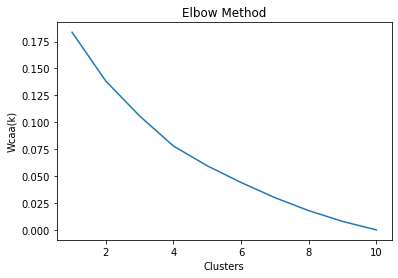

In [26]:
wcss = []
for i in range(1,11):
  kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
  kmeans.fit(X)
  wcss.append(kmeans.inertia_)

plt.plot(range(1,11), wcss)
plt.title("Elbow Method")
plt.xlabel("Clusters")
plt.ylabel("Wcaa(k)")
plt.show()

Maybe its dificult to see, but the most significant change of direction is the point 4.

In [27]:
kclusters = 4
kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
kmeans.fit(X)
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 1, 3, 1, 1, 0, 2], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [28]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
neighborhoods_venues_sorted

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,0,Central Toronto,Park,Café,Coffee Shop,Sandwich Place,Gym
1,0,Downtown Toronto,Coffee Shop,Café,Restaurant,Japanese Restaurant,Bakery
2,0,East Toronto,Greek Restaurant,Coffee Shop,Restaurant,Italian Restaurant,Park
3,0,East York,Bank,Indian Restaurant,Coffee Shop,Pizza Place,Sandwich Place
4,1,Etobicoke,Coffee Shop,Pizza Place,Pharmacy,Sandwich Place,Bank
5,3,Mississauga,Coffee Shop,Clothing Store,Cosmetics Shop,Performing Arts Venue,Tea Room
6,1,North York,Coffee Shop,Pizza Place,Clothing Store,Park,Mediterranean Restaurant
7,1,Scarborough,Clothing Store,Pharmacy,Coffee Shop,Sandwich Place,Pizza Place
8,0,West Toronto,Bar,Bakery,Pizza Place,Coffee Shop,Women's Store
9,2,York,Park,Coffee Shop,Beer Store,Gym,Bakery


In [29]:
Toronto_Merged = df_canada

Toronto_Merged = Toronto_Merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Borough')
Toronto_Merged

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,M3A,North York,Parkwoods,43.754326,-79.449117,1,Coffee Shop,Pizza Place,Clothing Store,Park,Mediterranean Restaurant
1,M4A,North York,Victoria Village,43.727600,-79.314800,1,Coffee Shop,Pizza Place,Clothing Store,Park,Mediterranean Restaurant
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.655500,-79.362600,0,Coffee Shop,Café,Restaurant,Japanese Restaurant,Bakery
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.722300,-79.450400,1,Coffee Shop,Pizza Place,Clothing Store,Park,Mediterranean Restaurant
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.656322,-79.380916,0,Coffee Shop,Café,Restaurant,Japanese Restaurant,Bakery
...,...,...,...,...,...,...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.651800,-79.507600,1,Coffee Shop,Pizza Place,Pharmacy,Sandwich Place,Bank
99,M4Y,Downtown Toronto,Church and Wellesley,43.665600,-79.383000,0,Coffee Shop,Café,Restaurant,Japanese Restaurant,Bakery
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C...",43.780400,-79.250500,0,Greek Restaurant,Coffee Shop,Restaurant,Italian Restaurant,Park
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.632500,-79.493900,1,Coffee Shop,Pizza Place,Pharmacy,Sandwich Place,Bank


In [31]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_Merged['Latitude'], Toronto_Merged['Longitude'], Toronto_Merged['Neighborhood'], Toronto_Merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# 4.- Examine Clusters

In [32]:
Toronto_Merged.loc[Toronto_Merged['Cluster Labels'] == 0, Toronto_Merged.columns[[1] + list(range(5, Toronto_Merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
2,Downtown Toronto,0,Coffee Shop,Café,Restaurant,Japanese Restaurant,Bakery
4,Downtown Toronto,0,Coffee Shop,Café,Restaurant,Japanese Restaurant,Bakery
8,East York,0,Bank,Indian Restaurant,Coffee Shop,Pizza Place,Sandwich Place
9,Downtown Toronto,0,Coffee Shop,Café,Restaurant,Japanese Restaurant,Bakery
14,East York,0,Bank,Indian Restaurant,Coffee Shop,Pizza Place,Sandwich Place
15,Downtown Toronto,0,Coffee Shop,Café,Restaurant,Japanese Restaurant,Bakery
19,East Toronto,0,Greek Restaurant,Coffee Shop,Restaurant,Italian Restaurant,Park
20,Downtown Toronto,0,Coffee Shop,Café,Restaurant,Japanese Restaurant,Bakery
23,East York,0,Bank,Indian Restaurant,Coffee Shop,Pizza Place,Sandwich Place
24,Downtown Toronto,0,Coffee Shop,Café,Restaurant,Japanese Restaurant,Bakery


In [33]:
Toronto_Merged.loc[Toronto_Merged['Cluster Labels'] == 1, Toronto_Merged.columns[[1] + list(range(5, Toronto_Merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,North York,1,Coffee Shop,Pizza Place,Clothing Store,Park,Mediterranean Restaurant
1,North York,1,Coffee Shop,Pizza Place,Clothing Store,Park,Mediterranean Restaurant
3,North York,1,Coffee Shop,Pizza Place,Clothing Store,Park,Mediterranean Restaurant
5,Etobicoke,1,Coffee Shop,Pizza Place,Pharmacy,Sandwich Place,Bank
6,Scarborough,1,Clothing Store,Pharmacy,Coffee Shop,Sandwich Place,Pizza Place
7,North York,1,Coffee Shop,Pizza Place,Clothing Store,Park,Mediterranean Restaurant
10,North York,1,Coffee Shop,Pizza Place,Clothing Store,Park,Mediterranean Restaurant
11,Etobicoke,1,Coffee Shop,Pizza Place,Pharmacy,Sandwich Place,Bank
12,Scarborough,1,Clothing Store,Pharmacy,Coffee Shop,Sandwich Place,Pizza Place
13,North York,1,Coffee Shop,Pizza Place,Clothing Store,Park,Mediterranean Restaurant


In [34]:
Toronto_Merged.loc[Toronto_Merged['Cluster Labels'] == 2, Toronto_Merged.columns[[1] + list(range(5, Toronto_Merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
16,York,2,Park,Coffee Shop,Beer Store,Gym,Bakery
21,York,2,Park,Coffee Shop,Beer Store,Gym,Bakery
56,York,2,Park,Coffee Shop,Beer Store,Gym,Bakery
63,York,2,Park,Coffee Shop,Beer Store,Gym,Bakery
64,York,2,Park,Coffee Shop,Beer Store,Gym,Bakery


In [35]:
Toronto_Merged.loc[Toronto_Merged['Cluster Labels'] == 3, Toronto_Merged.columns[[1] + list(range(5, Toronto_Merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
76,Mississauga,3,Coffee Shop,Clothing Store,Cosmetics Shop,Performing Arts Venue,Tea Room
